# Apoyo Diagnostico

## Comprensión del negocio y enfoque analítico

#### Objetivo
- Identificar los problemas que tiene un paciente por medio de una descripción dada por el médico.
- Proporcionar un problema acertado en base a la descripción del médico.
#### Criterios de Exito
- El modelo proporciona un resultado asertivo con respecto a una descripción del medico. Se debe tener una exactitud mayor al 70% para considerar el modelo exitoso para el apoyo de diagnosticos medicos.
#### Tareas de Analitica
- Las tareas de analitica de textos que se consideran adecuadas para cumplir con el objetivo del negocio son clasificación y agrupación.
#### Descripción del requerimiento de negocio
- El requerimiento del negocio es resuelto por medio de clasificación ya que al tener la variable objetivo la cual seria problems_described por medio de un modelo supervisado se puede encontrar las palabras claves que determinarian el problema del paciente. Por otro lado, al usar un modelo no supervisado el cual seria agrupacion se podrian generar grupo de palabras importantes en comun para poder determinar el problema que el paciente podria llegar a tener.

## Importaciones

In [24]:
import pandas as pd
import string
import nltk
from itertools import chain
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from scipy.sparse import coo_matrix, hstack

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lectura de archivo

In [2]:
# Lectura de los archivos proporcionados con la información de las descripciones de los medicos y el problema detectado
data_set_inicial = pd.read_csv('medical_text_clasificacion.csv')

In [3]:
# Se muestran los primeros datos del dataset para tener idea de como se veran los datos
data_set_inicial.head()

,medical_abstracts,problems_described
0,Cell lineage markers in human pancreatic cance...,1
1,Fatal pulmonary venoocclusive disease secondar...,5
2,High survival rate in advanced-stage B-cell ly...,5
3,Intracranial chordoma in a preadolescent. Case...,1
4,Analysis of prognostic factors and clinicopath...,3


In [4]:
# Se muestra la cantidad de filas y columnas que tiene el dataset
data_set_inicial.shape

(12000, 2)

In [5]:
# Se muestra el tipo de datos que tiene cada uno de las columnas
data_set_inicial.dtypes

medical_abstracts     object
problems_described     int64
dtype: object

# Analisis y perfilamiento de los datos

### Analisis de los datos en la columna problems_described

In [6]:
# Se recorre la columna de problems_described para poder ver si hay algun dato fuera de rango
for i in data_set_inicial["problems_described"]:
    if i < 0 or i > 5:
        print(i)

In [7]:
# Se cuenta la cantidad de valores de cada tipo de problema para analizar que tan repartidos estan los valores
data_set_inicial["problems_described"].value_counts().to_frame()

,problems_described
5,3993
1,2629
4,2536
3,1600
2,1242


In [8]:
# Se verifica la cantidad de valores nulos que hay en el dataset
data_set_inicial.isna().sum()

medical_abstracts     0
problems_described    0
dtype: int64

In [9]:
# Se eliminan los valores duplicados si llega a tenerlos
data_set_inicial = data_set_inicial.drop_duplicates()

### Analisis de los datos en la columna medical_abstracts

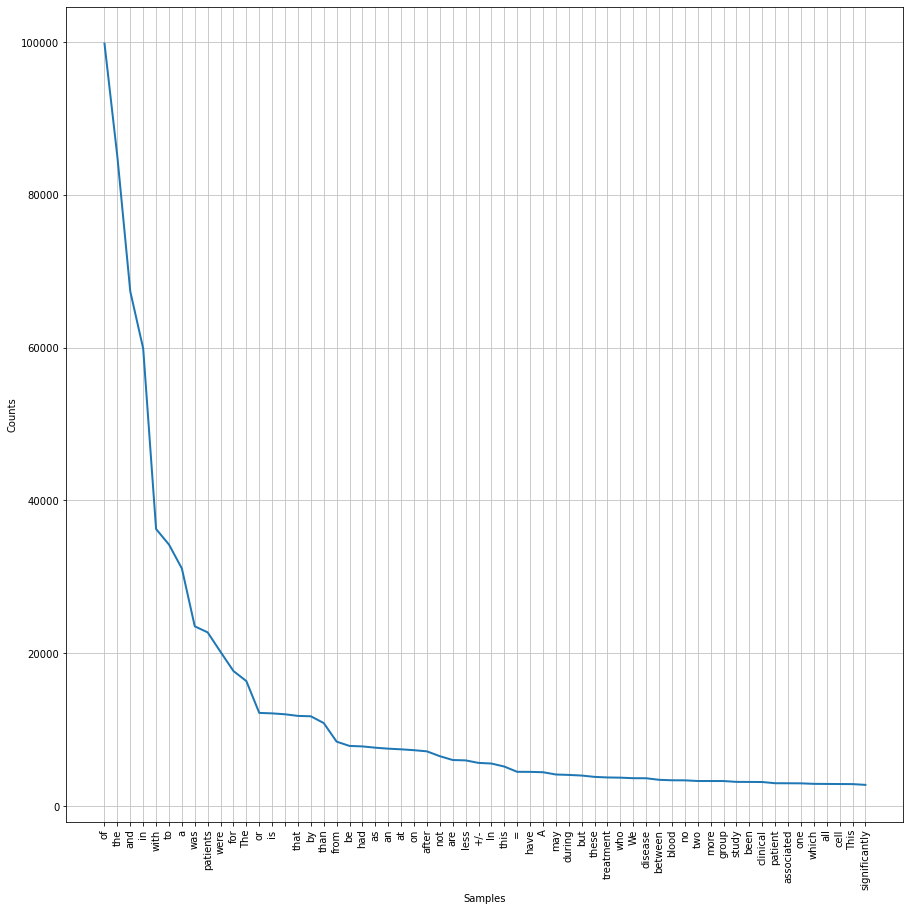

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [10]:
# Se presenta un diagrama con las palabras más comunes en todos los textos presentados en en medical abstract
frequency_dist = nltk.FreqDist(list(chain.from_iterable(data_set_inicial["medical_abstracts"].apply(lambda d: d.split(' ')).values)))
plt.figure(figsize=(15,15))
frequency_dist.plot(60,cumulative=False)

Como se puede observar en la grafica se determina que la mayoria de las palabras encontradas son las palabras más comunes en ingles que pertenecen a conectores, pronombres, entre otros. Con el fin de elaborar un estudio adecuado es necesario eliminar estas palabras y eliminar datos que no generan ningun aporte al modelo

### Arreglo de datos en la columna medical_abstracts

In [11]:
# Se genera una copia del dataset para hacer las modificaciones
data_set_texto = data_set_inicial

In [12]:
# Se recorren los textos del medical_abstract y se eliminan las puntuaciones, numeros y simbolos y se pasa todo a minusculas
for i in range(len(data_set_texto["medical_abstracts"])):
    texto = data_set_texto["medical_abstracts"][i]
    texto = texto.replace(".","")
    texto = texto.replace(";","")
    texto = texto.replace(",","")
    texto = texto.replace("(","")
    texto = texto.replace(")","")
    texto = texto.replace('"',"")
    texto = texto.replace(':',"")
    texto = texto.replace("1","")
    texto = texto.replace("2","")
    texto = texto.replace("3","")
    texto = texto.replace("4","")
    texto = texto.replace("5","")
    texto = texto.replace("6","")
    texto = texto.replace("7","")
    texto = texto.replace("8","")
    texto = texto.replace("9","")
    texto = texto.replace("0","")
    texto = texto.replace("=","")
    texto = texto.replace("%","")
    
    texto = texto.lower()
    data_set_texto["medical_abstracts"][i] = texto

In [13]:
# Se separan las palabras por espacios y remplazan por una lista de palabras
for i in range(len(data_set_texto)):
    data_set_texto["medical_abstracts"][i] = data_set_texto["medical_abstracts"][i].split(" ") 

In [14]:
# Se eliminan las palabras más comunes en ingles para poder tener un analisis mejor
s=set(stopwords.words('english'))
for i in range(len(data_set_texto["medical_abstracts"])):
    descMedicaRelevante = []
    for j in data_set_texto["medical_abstracts"][i]:
        if j not in s and j != "\n" and j != "" and j != "-":
            descMedicaRelevante.append(j)
    data_set_texto["medical_abstracts"][i] = descMedicaRelevante

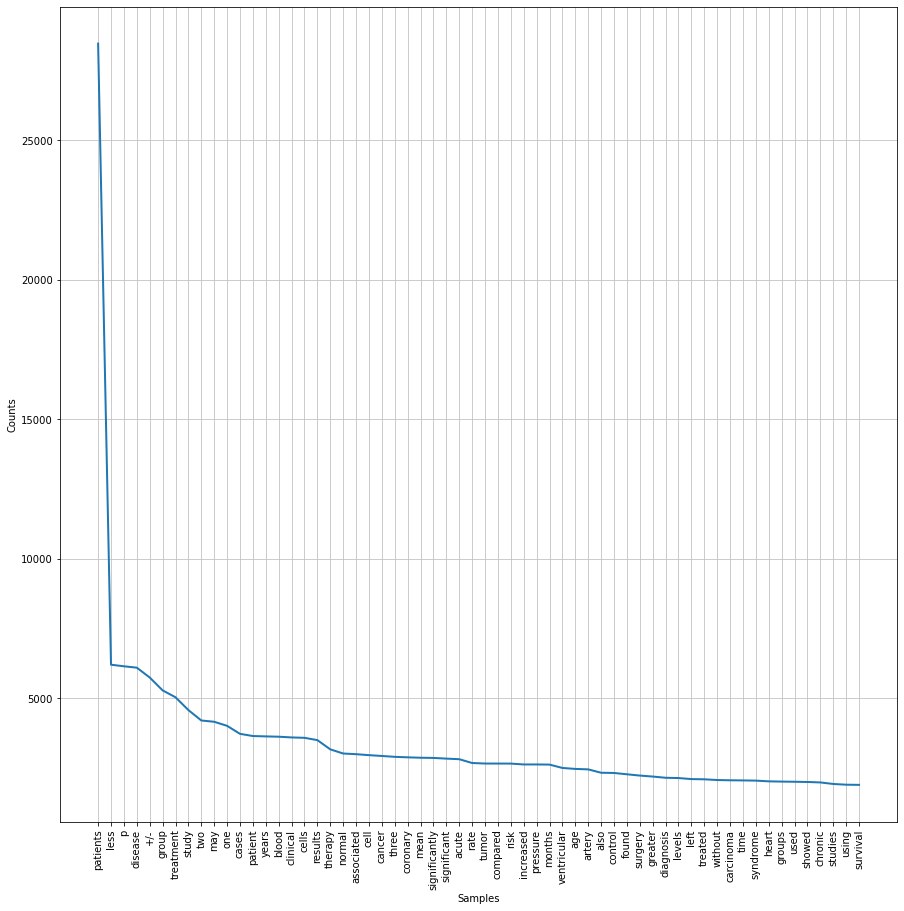

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [15]:
# Se presenta un grafico con las palabras más comunes en todos los textos
frequency_dist = nltk.FreqDist(list(chain.from_iterable(data_set_texto["medical_abstracts"].values)))
plt.figure(figsize=(15,15))
frequency_dist.plot(60,cumulative=False)

In [16]:
# Se presenta un conteo de la cantidad de valores diferentes que hay
len(list(chain.from_iterable(data_set_texto["medical_abstracts"].values))) 

1299229

In [17]:
# Se convierte el arreglo a texto para poder realizar el analisis esperado
text=data_set_texto["medical_abstracts"].apply(lambda d: ' '.join(d)).copy()
data_set_texto["medical_abstracts"] = text
data_set_texto.head()

,medical_abstracts,problems_described
0,cell lineage markers human pancreatic cancer n...,1
1,fatal pulmonary venoocclusive disease secondar...,5
2,high survival rate advanced-stage b-cell lymph...,5
3,intracranial chordoma preadolescent case repor...,1
4,analysis prognostic factors clinicopathologica...,3


## Modelamiento y Evaluacion

In [18]:
# Se vectorizan los datos de texto
tfidf_text=TfidfVectorizer(max_features=20000).fit(text)

In [19]:
# Se vectorizan los valores en la columna medical abstract para hacer el modelamiento
df_model = data_set_texto
X_text=tfidf_text.transform(df_model["medical_abstracts"])

### Random Forest Classifier

In [20]:
# Se definen los parametros a usar en el modelo de random forest
parameters={'criterion':["gini","entropy"],'n_estimators':[50,100,150]}

In [21]:
# Se implementa el modelo random forest
RFC=RandomForestClassifier(n_jobs=-1)

In [22]:
# Se genera el modelo
RFC_best=GridSearchCV(RFC,parameters).fit(X_text,df_model["problems_described"].values).best_estimator_

In [26]:
# Se imprime el reporte con las predicciones por cada uno de los problemas
print(classification_report(df_model["problems_described"].values, RFC_best.predict(X_text), labels=[1, 2, 3, 4, 5]))

              precision    recall  f1-score   support

           1       0.84      0.90      0.87      2629
           2       0.79      0.74      0.76      1242
           3       0.83      0.75      0.79      1600
           4       0.82      0.88      0.85      2536
           5       0.79      0.76      0.78      3993

    accuracy                           0.81     12000
   macro avg       0.81      0.81      0.81     12000
weighted avg       0.81      0.81      0.81     12000

